# Dataset Exploration

The aim of this notebook is to explore all the data, labels and metadata available in the dataset to extract a valuable analysis to perform a better data collection and preprocessing.

## Imports

In [1]:
import os
import multiprocessing
from collections import Counter
import ast

import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from lib.plot_utils import create_histogram
from lib.image_processing import load_numpy_data, get_stats
from lib.data_processing import get_labels_from_str

## Config

In [2]:
# Path to the folder with the subjects folders extracted
subjects_path = "../../../datasets/BIMCV-COVID19-cIter_1_2/covid19_posi/"

# Path to the TSV with all the images file pahts by subject and session
partitions_tsv_path = os.path.join(subjects_path, "derivatives/partitions.tsv")

# Path to the TSV with the main labels (and medical report) for each session
labels_tsv_path = os.path.join(subjects_path, "derivatives/labels/labels_covid_posi.tsv")

# Path to the TSV with the results of the COVID tests for each subject
tests_tsv_path = os.path.join(subjects_path, "derivatives/EHR/sil_reg_covid_posi.tsv")

# Maximum number of cores to use during some exploration steps
max_cores = multiprocessing.cpu_count()

## Load TSV of the dataset images

This TSV contains for each unique pair of subject ID and session ID the corresponding path to the image of that session. The path is relative to the folder containing all the subjects folders. The name of this folder should be "covid19_posi".

In [3]:
# Load dataframe with all the images by session and subject
cols = ["subject", "session", "filepath"]  # The original columns must be fixed
part_df = pd.read_csv(partitions_tsv_path, sep="\t", header=0, names=cols)
part_df.head()

,subject,session,filepath
0,sub-S03044,ses-E06138,./sub-S03044/ses-E06138/mod-rx/sub-S03044_ses-...
1,sub-S03044,ses-E06790,./sub-S03044/ses-E06790/mod-rx/sub-S03044_ses-...
2,sub-S03044,ses-E07712,./sub-S03044/ses-E07712/mod-rx/sub-S03044_ses-...
3,sub-S03045,ses-E06139,./sub-S03045/ses-E06139/mod-rx/sub-S03045_ses-...
4,sub-S03045,ses-E06910,./sub-S03045/ses-E06910/mod-rx/sub-S03045_ses-...


In [4]:
# Create auxiliary groupby views of the dataframe
part_groupby_sub = part_df.groupby(["subject"])
part_groupby_sess = part_df.groupby(["session"])

## Dataset counts

In [5]:
n_subjects = part_df['subject'].nunique()
n_sessions = part_df['session'].nunique()
n_images = len(part_df['filepath'])
print(f"Number of subjects: {n_subjects}")
print(f"Number of sessions: {n_sessions}")
print(f"Number of images: {n_images}")

Number of subjects: 4854
Number of sessions: 13368
Number of images: 23527


### Check if the sessions ids are unique

In [6]:
n_sub_sess_pairs = part_df.groupby(["subject", "session"]).ngroups
print(f"Total sessions: {n_sessions}")
print(f"Total unique pairs of subject & session: {n_sub_sess_pairs}")
print(f"Are sessions IDs unique? {n_sessions == n_sub_sess_pairs}")

Total sessions: 13368
Total unique pairs of subject & session: 13368
Are sessions IDs unique? True


### Sessions by subject

Count of sessions by subject:
 - mean: 2.75
 - median: 2.0
 - max: 38
 - min: 1


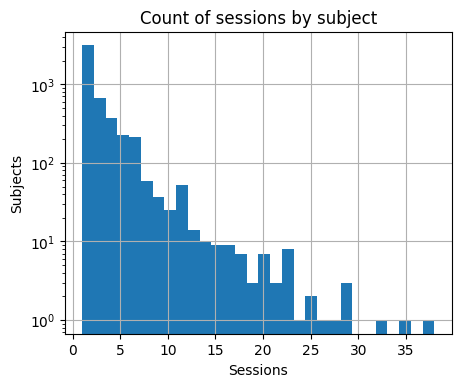

<Figure size 432x288 with 0 Axes>

In [7]:
# Get counts of sessions by subject
sess_count_by_sub = part_groupby_sub["session"].agg("nunique").values
print("Count of sessions by subject:")
print(f" - mean: {sess_count_by_sub.mean():.2f}")
print(f" - median: {np.median(sess_count_by_sub)}")
print(f" - max: {sess_count_by_sub.max()}")
print(f" - min: {sess_count_by_sub.min()}")
create_histogram(data=sess_count_by_sub,
                 title="Count of sessions by subject",
                 ylabel="Subjects",
                 xlabel="Sessions")

### Images by subject

Count of images by subject:
 - mean: 4.85
 - median: 3.0
 - max: 139
 - min: 1


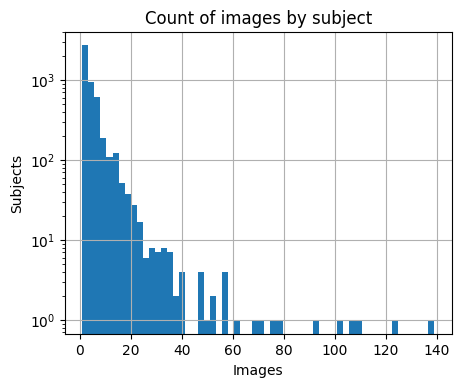

<Figure size 432x288 with 0 Axes>

In [8]:
# Get counts of images by subject
images_count_by_sub = part_groupby_sub["filepath"].agg("count").values
print("Count of images by subject:")
print(f" - mean: {images_count_by_sub.mean():.2f}")
print(f" - median: {np.median(images_count_by_sub)}")
print(f" - max: {images_count_by_sub.max()}")
print(f" - min: {images_count_by_sub.min()}")
create_histogram(data=images_count_by_sub,
                 title="Count of images by subject",
                 ylabel="Subjects",
                 xlabel="Images")

### Images by session

Count of images by session:
 - mean: 1.76
 - median: 1.0
 - max: 135
 - min: 1


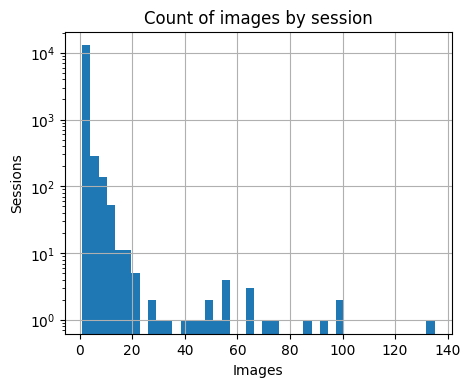

<Figure size 432x288 with 0 Axes>

In [9]:
# Get counts of images by session
images_count_by_sess = part_groupby_sess["filepath"].agg("count").values
print("Count of images by session:")
print(f" - mean: {images_count_by_sess.mean():.2f}")
print(f" - median: {np.median(images_count_by_sess)}")
print(f" - max: {images_count_by_sess.max()}")
print(f" - min: {images_count_by_sess.min()}")
create_histogram(data=images_count_by_sess,
                 title="Count of images by session",
                 ylabel="Sessions",
                 xlabel="Images")

## Images analysis

### Count of images views

Here we count how many images are anterior-posterior or posterior anterior. This views are the ones we are interested in.

In [10]:
img_files = part_df["filepath"].values  # Get all the paths to the images

# Filter by view
ap_pa_img_files = []  # Anterior-Posterior (AP) and Posterior-Anterior (PA)
not_ap_img_files = []
for f_name in img_files:
    if "vp-ap" in f_name or "vp-pa" in f_name:
        ap_pa_img_files.append(f_name)
    else:
        not_ap_img_files.append(f_name)
        
print(f"AP and PA images count: {len(ap_pa_img_files)}")
print(f"Other views count: {len(not_ap_img_files)}")

AP and PA images count: 13141
Other views count: 10386


### Check images file extensions

In [11]:
for view, images in [("AP/PA", ap_pa_img_files), ("other", not_ap_img_files)]:
    count_png = 0
    count_nii = 0
    for filepath in images:
        if filepath.endswith("png"):
            count_png += 1
        elif filepath.endswith("nii.gz"):
            count_nii += 1
        else:
            print(f"Warning: Unexpected image extension in {filepath}")

    print(f"Images file extensions in {view} views:")
    print(f" - png: {count_png}")
    print(f" - nii.gz: {count_nii}")

Images file extensions in AP/PA views:
 - png: 13141
 - nii.gz: 0
Images file extensions in other views:
 - png: 3699
 - nii.gz: 6687


### Explore pixels data

In the next cell we load all the images corresponding to the views AP and PA to extract some information about them.

### WARNING: The execution of this cell can take up to one hour to complete.

In [12]:
# Convert the relative paths to the full path required to access the images
img_full_paths = [os.path.join(subjects_path, img_file) for img_file in ap_pa_img_files]

# Compute the stats with parallel processing
with multiprocessing.Pool(max_cores) as p:
    stats = list(tqdm(p.imap(get_stats, img_full_paths), total=len(img_full_paths)))
    
means, stds, maxs, mins, shapes = zip(*stats)  # Split the stats by types

100%|██████████| 13141/13141 [08:34<00:00, 25.53it/s]


Show a histogram with the means extracted from each image over all its pixels

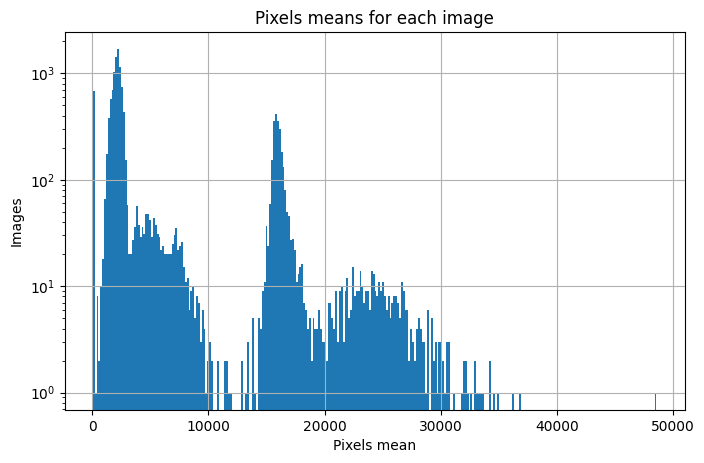

<Figure size 432x288 with 0 Axes>

In [13]:
create_histogram(data=means,
                 title="Pixels means for each image",
                 ylabel="Images",
                 xlabel="Pixels mean",
                 bins=300,
                 fig_size=(8, 5))

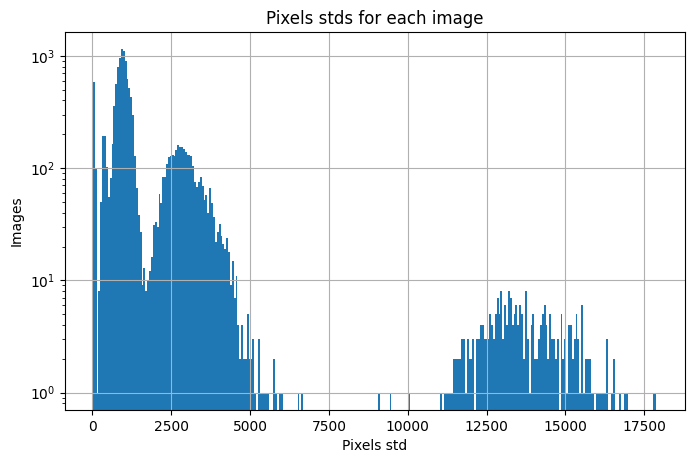

<Figure size 432x288 with 0 Axes>

In [14]:
create_histogram(data=stds,
                 title="Pixels stds for each image",
                 ylabel="Images",
                 xlabel="Pixels std",
                 bins=300,
                 fig_size=(8, 5))

Show a histogram with the maximum pixels values extracted from each image

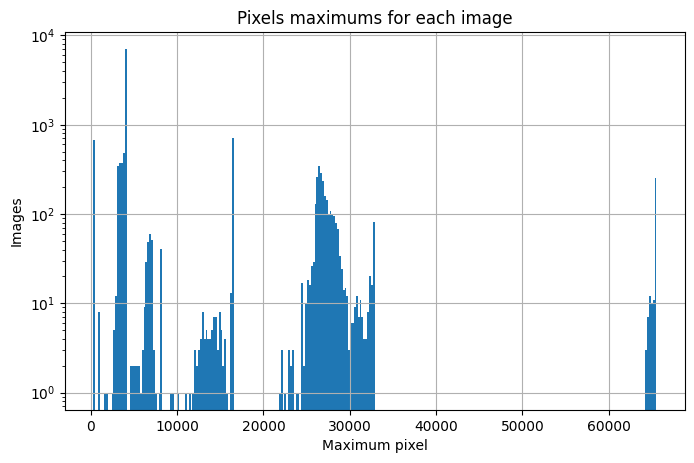

<Figure size 432x288 with 0 Axes>

In [15]:
create_histogram(data=maxs,
                 title="Pixels maximums for each image",
                 ylabel="Images",
                 xlabel="Maximum pixel",
                 bins=300,
                 fig_size=(8, 5))

Show a histogram with the minimum pixels values extracted from each image

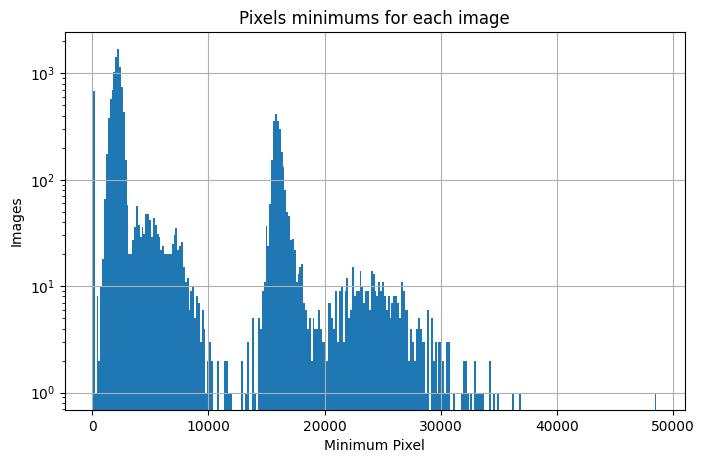

<Figure size 432x288 with 0 Axes>

In [16]:
create_histogram(data=mins,
                 title="Pixels minimums for each image",
                 ylabel="Images",
                 xlabel="Minimum Pixel",
                 bins=300,
                 fig_size=(8, 5))

Count different images shapes

In [17]:
print("Images shapes count:")
sorted_counts = np.array(sorted(dict(Counter(shapes)).items(), key=lambda x: x[1], reverse=True))
for shape, count in sorted_counts:
    print(f"{shape}: {count}")

Images shapes count:
(2336, 2836): 1166
(3480, 4248): 1085
(3488, 4256): 1027
(3480, 4240): 852
(2544, 3056): 814
(2320, 2832): 630
(2800, 3408): 439
(3032, 3032): 315
(1140, 1387): 313
(2436, 3032): 281
(3052, 3052): 273
(2021, 2021): 264
(2539, 3050): 256
(2416, 2872): 255
(2540, 2880): 248
(2400, 2880): 196
(1760, 2140): 181
(2801, 2802): 159
(2991, 2992): 140
(2874, 2840): 119
(2330, 2846): 114
(2536, 3048): 114
(4020, 4891): 90
(2520, 3032): 82
(2010, 2446): 79
(4240, 3480): 74
(2801, 2798): 65
(2428, 2428): 62
(2010, 2431): 46
(2560, 3072): 44
(2012, 2012): 44
(3006, 3006): 38
(3000, 3000): 37
(2874, 2808): 35
(2801, 2992): 35
(2014, 2014): 34
(2832, 2320): 34
(3052, 3004): 34
(4248, 3480): 31
(3072, 2560): 30
(3520, 4280): 28
(3056, 2544): 28
(3198, 3056): 26
(3052, 3012): 26
(2446, 2010): 25
(3052, 3020): 23
(2320, 2828): 21
(3052, 2996): 20
(3052, 3028): 18
(3488, 3488): 17
(2874, 2816): 16
(2996, 3052): 15
(3052, 2980): 14
(2180, 2660): 13
(2548, 3060): 13
(3050, 2539): 12
(4

<ipython-input-17-9f3535d3f45d>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sorted_counts = np.array(sorted(dict(Counter(shapes)).items(), key=lambda x: x[1], reverse=True))


Scatter plot to view the general shape distributions. To create this plot we take into account the top "N" most frequent shapes.

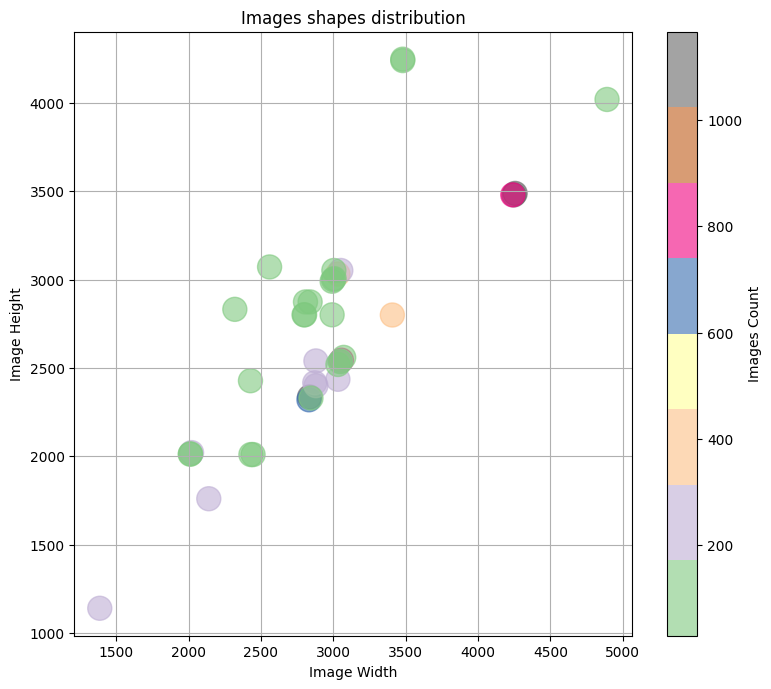

In [18]:
# Select the top 40 most frequent shapes
N = 40
selected_counts = sorted_counts[:N,:]

heights, widths = zip(*selected_counts[:,0]) # Split height and width values

colors = np.array(selected_counts[:,1])  # Get color form the count number
area = 300  # Size of the circles
plt.figure(figsize=(9,8), dpi=100)
plt.scatter(widths, heights, s=area, c=colors, cmap="Accent", alpha=0.6)
plt.grid()
cbar = plt.colorbar()
cbar.ax.set_ylabel("Images Count")
plt.title("Images shapes distribution")
plt.ylabel("Image Height")
plt.xlabel("Image Width")
plt.show()

## Labels Analysis

### Load TSV with labels by session

In [12]:
labels_df = pd.read_csv(labels_tsv_path, sep="\t")
labels_df.head()

,Unnamed: 0,PatientID,ReportID,Report,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS
0,0,sub-S03080,ses-E07791,se compara con rx previa . estabilidad radio...,"['unchanged', 'infiltrates']","['loc lower lung field', 'loc peripheral', 'lo...","['unchanged', 'infiltrates', 'loc peripheral',...",[C0277877],"[C0205100,C0929434,C0444532,C0443246]"
1,1,sub-S03080,ses-E06235,juicio clinico valorar evolucion radiologica n...,"['COVID 19', ' consolidation', ' pneumonia']","['loc middle lung field', 'loc right']","['COVID 19', ' consolidation', ' pneumonia', '...","[C5203670,C0521530,C0032285]","[C0929434,C0444532]"
2,2,sub-S03080,ses-E06174,se compara con estudios previos . poco inspir...,"['unchanged', 'increased density']","['loc lung field', 'loc peripheral', 'loc left...","['unchanged', 'exclude', 'increased density', ...",[C1443940],"[C0225759,C0205100,C0443246,C0929434,C0444532]"
3,3,sub-S03080,ses-E07930,se raliza se compara con estudio previo del 06...,['infiltrates'],"['loc middle lung field', 'loc lung field', 'l...","['infiltrates', 'loc middle lung field', 'loc ...",[C0277877],"[C0929434,C0225759,C0205100]"
4,4,sub-S03080,ses-E06408,poco inspirada . no se observan imagenes suge...,['normal'],"['loc cardiac', 'loc costophrenic angle', 'loc...","['exclude', 'normal', 'loc cardiac', 'loc cost...",[C0205307],"[C1522601,C0230151,C0504099,C0504100]"


### Look for nan values

In [13]:
print("NaNs count by column:")
print(labels_df.isna().sum())

NaNs count by column:
Unnamed: 0                          0
PatientID                           0
ReportID                            0
Report                           1233
Labels                             20
Localizations                      22
LabelsLocalizationsBySentence      24
labelCUIS                          22
LocalizationsCUIS                  23
dtype: int64


### Check subjects and sessions IDs

In [14]:
n_subjects = labels_df['PatientID'].nunique()
n_sessions = labels_df['ReportID'].nunique()
print(f"Number of subjects: {n_subjects}")
print(f"Number of sessions: {n_sessions}")

# Compare the sets of unique sessions IDs of each DataFrame
imgs_df_sess = set(part_df['session'])
labels_df_sess = set(labels_df["ReportID"])
sess_diff1 = len(imgs_df_sess.difference(labels_df_sess))
sess_diff2 = len(labels_df_sess.difference(imgs_df_sess))
print(f"Number of images without labels: {sess_diff1}")
print(f"Number of labels without image: {sess_diff2}")

Number of subjects: 4898
Number of sessions: 13635
Number of images without labels: 0
Number of labels without image: 267


### Count labels

Note: The labels in the column "Labels" are strings representing a python list
      with the actual strings of the labels

In [15]:
# Replace the nans by the label NONE
labels_df["Labels"] = labels_df["Labels"].fillna('["NONE"]')

labels_counter = Counter()
for labels_str in labels_df["Labels"]:
    labels_list = get_labels_from_str(labels_str, verbose=True)  # Get a list object from the str
    labels_counter.update(labels_list)  # Update the counter for each label in the list


Failed to process labels: "['aortic elongation', ' cardiomegaly', 'tracheostomy tube', 'central venous ca"
Failed to process labels: "['atelectasis', 'volume loss', 'hiatal hernia', 'adenopathy', ' calcified adenopathy', 'pleural effusion', 'bronchiectasis', ' cavitation', ' lobar atelectasis', 'nodule', 'hyperinflated lung', '', 'ground glass pattern', ' pneumonia', 'emp"


Show counts results

In [16]:
print(f"Total number of unique labels: {len(labels_counter)}")

print("\nLabels count (sorted):")
for label, counter in sorted(labels_counter.items(), key=lambda x: x[1], reverse=True):
    print(f'"{label}": {counter}')

Total number of unique labels: 180

Labels count (sorted):
"COVID 19": 2356
"increased density": 2215
"pneumonia": 2181
"normal": 1884
"unchanged": 1816
"exclude": 1702
"alveolar pattern": 1558
"interstitial pattern": 1549
"consolidation": 1402
"infiltrates": 1392
"": 1249
"ground glass pattern": 1002
"pleural effusion": 988
"cardiomegaly": 894
"suboptimal study": 574
"central venous catheter": 443
"aortic elongation": 419
"laminar atelectasis": 400
"aortic atheromatosis": 384
"costophrenic angle blunting": 361
"COVID 19 uncertain": 313
"NSG tube": 276
"endotracheal tube": 271
"nodule": 263
"viral pneumonia": 254
"vertebral degenerative changes": 224
"fibrotic band": 194
"atypical pneumonia": 193
"atelectasis": 186
"bronchovascular markings": 174
"emphysema": 160
"adenopathy": 155
"calcified densities": 153
"volume loss": 151
"central venous catheter via jugular vein": 146
"bronchiectasis": 136
"tracheostomy tube": 128
"hiatal hernia": 127
"pacemaker": 125
"reticular interstitial patte

### Count sets of labels

In [17]:
# List the sets of labels to look for
labels_sets = [["COVID 19", "pneumonia"], ["COVID 19", "infiltrates"], ["pneumonia", "infiltrates"],
               ["COVID 19"], ["pneumonia"], ["infiltrates"], ["normal"]]
labels_sets_counter = Counter()  # To store the aparitions of each labels set

for labels_str in labels_df["Labels"]:
    labels_list = get_labels_from_str(labels_str, verbose=True)  # Get a list object from the str

    # Check if any labels set is a subset of the labels_list
    for l_set in labels_sets:
        if set(l_set).issubset(labels_list):
            labels_sets_counter.update([" + ".join(l_set)])  # Update the counter of the labels set

Failed to process labels: "['aortic elongation', ' cardiomegaly', 'tracheostomy tube', 'central venous ca"
Failed to process labels: "['atelectasis', 'volume loss', 'hiatal hernia', 'adenopathy', ' calcified adenopathy', 'pleural effusion', 'bronchiectasis', ' cavitation', ' lobar atelectasis', 'nodule', 'hyperinflated lung', '', 'ground glass pattern', ' pneumonia', 'emp"


In [18]:
print("\nLabels sets count (sorted):")
for label, counter in sorted(labels_sets_counter.items(), key=lambda x: x[1], reverse=True):
    print(f'"{label}": {counter}')


Labels sets count (sorted):
"COVID 19": 2356
"pneumonia": 2119
"normal": 1884
"infiltrates": 1374
"COVID 19 + pneumonia": 1327
"pneumonia + infiltrates": 281
"COVID 19 + infiltrates": 277


## Analyze COVID tests labels

### Load TSV with COVID tests results

In [19]:
tests_df = pd.read_csv(tests_tsv_path, sep="\t")
tests_df.head()

,label,subject,date,test,result,participant,Unnamed: 6
0,1,1,20.03.2020,PCR,POSITIVO,sub-S03044,NaN
1,1,1,18.03.2020,PCR,POSITIVO,sub-S03044,NaN
2,2,2,19.04.2020,PCR,NEGATIVO,sub-S03046,NaN
3,2,2,18.03.2020,PCR,POSITIVO,sub-S03046,NaN
4,3,3,16.03.2020,PCR,POSITIVO,sub-S03045,NaN


Look for nan values

In [20]:
print("NaNs count by column:")
print(tests_df.isna().sum())

NaNs count by column:
label              0
subject            0
date               0
test               0
result             0
participant        0
Unnamed: 6     26733
dtype: int64


### Count tests types

In [21]:
print("Test types count:")
test_types_counts = tests_df["test"].value_counts()
print(test_types_counts)

Test types count:
PCR    16442
IGG     4273
ACT     3294
IGM     2724
Name: test, dtype: int64


### Count tests results

In [22]:
print("Test results count:")
test_res_counts = tests_df["result"].value_counts()
print(test_res_counts)

Test results count:
POSITIVO         14253
NEGATIVO         11393
INDETERMINADO     1087
Name: result, dtype: int64


## Use COVID tests to improve data labeling

For each subject we compare the labels of each session with the results available from the COVID tests labels.
If we detect that some session hasn't the 'COVID 19' label but the subject has a POSITIVE COVID test with approximately the same date, we add the 'COVID 19' label to the session.

### Prepare data

In [23]:
# Get only the positive tests
posi_tests = tests_df[tests_df["result"] == "POSITIVO"].copy()

# Convert dates from strings to datetime objects
posi_tests["date"] = pd.to_datetime(posi_tests["date"], format="%d.%m.%Y")

# Group tests by subject ID
#  - Note: A subject can have several tests
posi_tests_by_sub = posi_tests.groupby(["participant"])

# Group the sessions labels by subject ID
labels_by_sub = labels_df.groupby(["PatientID"])

### Configure parameters

In [24]:
'''
Set the range of days before and after a COVID test to
take the test result as valid to label a session
'''
valid_prev_days = 0  # Number of days before the COVID test
valid_post_days = 0  # Number of days after the COVID test

verbose = 1  # 0: only errors, >0: Full logs

### Process tests data

In [25]:
fixed_labels = 0  # To count the sessions labels modified adding 'COVID 19'

# Avoid to change labels of sessions with one of these labels
#labels_to_avoid = []
labels_to_avoid = ["exclude", "normal"]
# Only try to change the labels os sessions with at least one of these labels
#mandatory_labels = []
mandatory_labels = ["COVID 19 uncertain", "infiltrates", "pneumonia"]

# Iterate over the groups of tests of each subject
#  - IMPORTANT: "posi_tests_by_sub" only contains positive tests
for sub_id, sub_tests in posi_tests_by_sub:
    # Load subject sessions data
    sub_sessions_tsv = os.path.join(subjects_path, sub_id, f"{sub_id}_sessions.tsv")
    # Check if the data exists
    if not os.path.isfile(sub_sessions_tsv):
        print("---------------------------------------------------")
        if not os.path.isdir(os.path.dirname(sub_sessions_tsv)):
            print(f'| Error: Missing subject directory of "{sub_id}"')
        else:
            print(f'| Error: Missing file "{sub_sessions_tsv}"')
        print("---------------------------------------------------")
        continue  # skip the subject     
    sub_sessions_df = pd.read_csv(sub_sessions_tsv, sep="\t")
    
    # Convert sessions dates from strings to datetime objects
    sub_sessions_df["study_date"] = pd.to_datetime(sub_sessions_df["study_date"], format="%Y%m%d")
    
    # Get the list of labels for each session of the subject
    sub_sessions_labels = labels_by_sub.get_group(sub_id)[['ReportID','Labels']]
    
    # Compare the labels of each session with the COVID tests
    for idx, sess_row in sub_sessions_df.iterrows():
        sess_id = sess_row["session_id"]
        sess_date = sess_row["study_date"]
        
        # Get the list of labels of the current session
        sess_labels_row = sub_sessions_labels[sub_sessions_labels["ReportID"] == sess_id]
        labels_str = sess_labels_row["Labels"].values[0]
        labels_list = get_labels_from_str(labels_str, verbose=True)  # Get a list object from the str
        
        # Skip sessions with the COVID label (Nothing to change here)
        if 'COVID 19' in labels_list:
            continue
        # Skip sessions with at least one of the labels to avoid
        if any(l in labels_to_avoid for l in labels_list):
            continue
        # Skip sessions without at least one mandatory label
        if len(mandatory_labels) and not any(l in mandatory_labels for l in labels_list):
            continue
            
        # Look if any of the tests can affect the session labels (by time difference)
        for test_date in sub_tests["date"]:
            # Compute time difference in days
            days_diff = (sess_date - test_date).days

            # Check if is a valid difference to fix the label
            if -valid_prev_days <= days_diff <= valid_post_days:
                if verbose:
                    print(f"FIX: Sess ID: {sess_id} Days diff: {days_diff} - session labels: {labels_list}")
                fixed_labels += 1               
                break  # Don't look for more tests

FIX: Sess ID: ses-E06790 Days diff: 0 - session labels: ['chronic changes', 'increased density', 'pneumonia']
FIX: Sess ID: ses-E06910 Days diff: 0 - session labels: ['atypical pneumonia', 'consolidation', 'pneumonia']
FIX: Sess ID: ses-E20387 Days diff: 0 - session labels: ['atelectasis', 'infiltrates', 'ground glass pattern', 'bronchiectasis', 'pleural effusion', 'tracheostomy tube', 'pneumonia', 'pulmonary edema', 'pulmonary fibrosis']
FIX: Sess ID: ses-E07054 Days diff: 0 - session labels: ['unchanged', 'infiltrates']
FIX: Sess ID: ses-E06578 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E07055 Days diff: 0 - session labels: ['hilar congestion', 'pleural effusion', 'pulmonary edema', 'COVID 19 uncertain']
FIX: Sess ID: ses-E06960 Days diff: 0 - session labels: ['cardiomegaly', 'mediastinal enlargement', 'COVID 19 uncertain', 'infiltrates']
FIX: Sess ID: ses-E06883 Days diff: 0 - session labels: ['pneumonia', 'viral pneumonia']
FIX: Sess ID: ses-E06980 Days diff: 

In [26]:
print(f"Sessions labels modified adding 'COVID 19': {fixed_labels}")

Sessions labels modified adding 'COVID 19': 532
